<a href="https://colab.research.google.com/github/NicoPP1/PDI/blob/main/asd/TP8Parma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico Nº8 Procesamiento Digital de Imágenes - Reconstrucción y cuantización.
### Autor: Nicolás Daniel Parma Paternostro
### Consigna: 

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

• Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

• Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

## Fecha de entrega: 08 de Dicembre.

##Subir la imagen IC2 adjunta en el formulario de Google

###Librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

###Funciones para trabajar en los espacios RGB e YIQ

In [2]:
#Función para clipear la luminancia
def clipY(mat):
    mat = np.clip(mat,0.0,1.0)
    return mat

#Función para clipear la componente en fase
def clipI(mat):
    mat = np.clip(mat,-0.5957,0.5957)          
    return mat

#Función para clipear la el componente en cuadratura
def clipQ(mat):
    mat = np.clip(mat,-0.5226,0.5226)          
    return mat

#Función para obtener componentes RGB de una imagen y devolverlo en el espacio YIQ
def RGB2YIQ(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r,g,b = RGB(img)
    r = r/255 #normalizo canales
    g = g/255 #normalizo canales
    b = b/255 #normalizo canales

    Y = (r*0.299+g*0.587+b*0.114)
    I = (r*0.595716-g*0.274453-b*0.321263)
    Q = (r*0.211456-g*0.522591+b*0.311135)

    return(Y,I,Q)

#Función para obtener los canales RGB de una imagen
def RGB(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    return r,g,b

#Función para obtener una imagen RGB a partir de los componentes YIQ modificadas
def YIQ2RGB(Y,I,Q):
    Y = clipY(Y) #función para clipear luminancia
    I = clipI(I) #función para clipear luminancia
    Q = clipQ(Q) #función para clipear luminancia

    dimension = Y.shape

    r = np.zeros((dimension[0],dimension[1]), dtype = float)
    g = np.zeros((dimension[0],dimension[1]), dtype = float)
    b = np.zeros((dimension[0],dimension[1]), dtype = float)

    r = (Y+0.9563*I+0.621*Q)*255
    g = (Y-0.2721*I-0.6474*Q)*255
    b = (Y-1.1070*I+1.7046*Q)*255

    r = np.clip(r,0,255)
    g = np.clip(g,0,255)
    b = np.clip(b,0,255)

    img = np.zeros((dimension[0],dimension[1],3),dtype = 'uint8') #Transformo a tipo de dato uint8 ya que es el requerido para mostrar las imágenes
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b

    return(img)

## Upsampling

In [3]:
def upConstante(Y):
    Yupcte = np.zeros((2*heightY,2*widthY))
    for i in range(heightY):
        for j in range(widthY):
                Yupcte[2*i:2*i+2,2*j:2*j+2] = Y[i,j]
            
    return Yupcte

def upBilineal(Y):
    Yupbili = np.zeros((2*heightY,2*widthY))
    for i in range(heightY-1):
        for j in range(widthY-1):
                Yupbili[2*i,2*j] = Y[i,j]            
                Yupbili[2*i+1,2*j] = (Y[i,j]+Y[i+1,j])/2
                Yupbili[2*i,2*j+1] = (Y[i,j]+Y[i,j+1])/2
                Yupbili[2*i+1,2*j+1] = (Y[i,j]+Y[i,j+1]+Y[i+1,j]+Y[i+1,j+1])/4

    Yupbili = np.clip(Yupbili,0,1)
    return Yupbili 

def upBicubico(Y):
    Yupbicu = np.zeros((2*heightY-2,2*widthY-2))
    for i in range(heightY-2):
        for j in range(widthY-2):
            if ((i == 0) and (j == 0)):
                print("inicio")
            else:
                Yupbicu[2*i,2*j] = Y[i,j]            
                Yupbicu[2*i+1,2*j] = (-Y[i-1,j]+5*Y[i,j]+5*Y[i+1,j]-Y[i+2,j])/8
                Yupbicu[2*i,2*j+1] = (-Y[i,j-1]+5*Y[i,j]+5*Y[i,j+1]-Y[i,j+2])/8

    for i in range(heightY-2):
        for j in range(widthY-2):
            if ((i == 0) and (j == 0)):
                print("inicio")
            else:
                Yupbicu[2*i+1,2*j+1] = (((-Yupbicu[2*i-2,2*j]+5*Yupbicu[2*i-1,2*j]+5*Yupbicu[2*i+1,2*j]-Yupbicu[2*i+2,2*j])/8)+((-Yupbicu[2*i,2*j-2]+5*Yupbicu[2*i,2*j-1]+5*Yupbicu[2*i,2*j+1]-Yupbicu[2*i,2*j+2])/8))/2
            
    Yupbicu = np.clip(Yupbicu,0,1)

    return Yupbicu

## Downsampling

In [4]:
def downConstante(Y):
    Ydowncte = np.zeros((heightY//2,widthY//2))
    for i in range(heightY//2):
        for j in range(widthY//2):
                Ydowncte[i,j] = Y[2*i,2*j]
    return Ydowncte

def downBilineal(Y):
    Ydownbili = np.zeros((heightY//2,widthY//2))
    for i in range(heightY//2):
        for j in range(widthY//2):
                Ydownbili[i,j] = (Y[2*i,2*j]+Y[2*i+1,2*j]+Y[2*i,2*j+1]+Y[2*i+1,2*j+1])/4        

    Ydownbili = np.clip(Ydownbili,0,1)

    return Ydownbili

def downBicubico(Y):
    Ydownbicu = np.zeros((heightY//2-2,widthY//2-2))
    for i in range(heightY//2-2):
        for j in range(widthY//2-2):
            if ((i == 0) and (j == 0)):
                print("inicio")
            else:
                Ydownbicu[i,j] = (((-Y[2*i-1,2*j]+5*Y[2*i,2*j]+5*Y[2*i+1,2*j]-Y[2*i+2,2*j])/8)+(-Y[2*i,2*j-1]+5*Y[2*i,2*j]+5*Y[2*i,2*j+1]-Y[2*i,2*j+2])/8)/2       

    Ydownbicu = np.clip(Ydownbicu,0,1)
    return Ydownbicu

## Cuantización

In [6]:
def find_nearest(k, value):

    array = np.linspace(0,1,k)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def cuantizacionUniforme(Y,k):
    Ycuant = np.zeros((heightY,widthY))
    for i in range(heightY):
        for j in range(widthY):
            Ycuant[i,j] = find_nearest(k,Y[i,j])
    return Ycuant

def ditheringAleatorio(Y,k):
    Ydit = np.zeros((heightY,widthY)) 
    for i in range(heightY):
        for j in range(widthY):
            Ydit[i,j] = Y[i,j]*(k-1)+(np.random.rand()-0.5)/(k-1)

    Ydit = np.clip(Ydit,0,1)
    return Ydit

def difusionError(Y):
    Ydif = np.zeros((heightY,widthY))

    for i in range(heightY):
        error = 0.0
        for j in range(widthY):
            Ydif[i,j] = np.round(Ycuant[i,j] + error,2)
            error = error + Ycuant[i,j] - Y[i,j]
            
    # Ydif = np.clip(Ydif,0,1)
    return Ydif

### Aplicativo que permite seleccionar la imagen de un circuito integrado (IC o IC2) o de un fondo de ojo y seleccionar la operación a aplicar. Se puede descargar la imagen obtenida al aplicar el filtro presionando el botón "descargar imagen", la misma se guarda como img.jpg. 


In [19]:
import ipywidgets as widgets
from IPython.display import display

aplicar = widgets.Button(description = "aplicar operacion")
descarga = widgets.Button(description = "descargar imagen")
#@title Ingrese la URL de la imagen deseada y luego seleccione el filtro a realizar { run: "auto", vertical-output: true }

u = "IC2" #@param ["IC", "IC2", "Fondo de ojo", "Imagen descargada"]
if u == "IC":
    url = "https://www.electan.com/images/Sparkfun/11107-01.jpg"
elif u == "Fondo de ojo":
    url = "https://www.rahhal.com/blog/wp-content/uploads/2015/07/fondo-ojo-normal.jpg"
elif u == "Imagen descargada":
    url = "/content/img.jpg"
elif u == "IC2":
    url = "/content/IC2.png"

img = imageio.imread(url)

op = "upConstante" #@param ["upConstante", "upBilineal", "upBicubico", "downConstante", "downBilineal", "downBicubico", "cuantizacionUniforme", "ditheringAleatorio", "difusionError"]
k = 2 #@param {type:"integer"}

Y,I,Q = RGB2YIQ(img)

shapeY = Y.shape
heightY = shapeY[0]
widthY = shapeY[1]


def on_aplicar_clicked(b):
    print(f"Aplicar {op} a {u}")

    if op == 'upConstante':
        Yop = upConstante(Y)
    elif op == 'upBilineal':
        Yop = upBilineal(Y)
    elif op == 'upBicubico':
        Yop = upBicubico(Y)
    if op == 'downConstante':
        Yop = downConstante(Y)
    elif op == 'downBilineal':
        Yop = downBilineal(Y)
    elif op == 'downBicubico':
        Yop = downBicubico(Y)
    if op == 'cuantizacionUniforme':
        Yop = cuantizacionUniforme(Y,k)
    elif op == 'ditheringAleatorio':
        Yop = ditheringAleatorio(Y,k)
    elif op == 'difusionError':
        Yop = difusionError(Y)

    dpi = plt.rcParams['figure.dpi']
    figsize1 = widthY / float(dpi), heightY / float(dpi)
    figsize2 = 2*widthY / float(dpi), 2*heightY / float(dpi)

    if ((op == "upConstante") or (op == "upBilineal") or (op == "upBicubico")):
        plt.figure(figsize = figsize2)
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure(figsize = figsize2)
        plt.title(op)
        plt.imshow(Yop,'gray')
    elif ((op == "downConstante") or (op == "downBilineal") or (op == "downBicubico")):
        plt.figure(figsize = figsize1)
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure(figsize = figsize1)
        plt.title(op)
        plt.imshow(Yop,'gray')
    else:
        plt.figure()
        plt.title("original")
        plt.imshow(Y,'gray')

        plt.figure()
        plt.title(op)
        plt.imshow(Yop,'gray')
    print("Aplicado")

def on_descarga_clicked(b):
    plt.imsave('/content/img.jpg',YopMorph,cmap = 'gray')
    plt.imshow(YopMorph,cmap = 'gray')
    print("Descarga realizada correctamente")

    
aplicar.on_click(on_aplicar_clicked)
descarga.on_click(on_descarga_clicked)

display(aplicar,descarga)

Button(description='aplicar operacion', style=ButtonStyle())

Button(description='descargar imagen', style=ButtonStyle())

### Aplico todas las operaciones a la imagen anterior para poder visualizar los efectos de cada una en particular

In [21]:
Yupcte = upConstante(Y)
Yupbili = upBilineal(Y)
Yupbicu = upBicubico(Y)

Ydowncte = downConstante(Y)
Ydownbili = downBilineal(Y)
Ydownbicu = downBicubico(Y)

Ycuant = cuantizacionUniforme(Y,k)
Ydit = ditheringAleatorio(Y,k)
Ydif = difusionError(Y)

inicio
inicio
inicio


### Visualización de las distintas operaciones

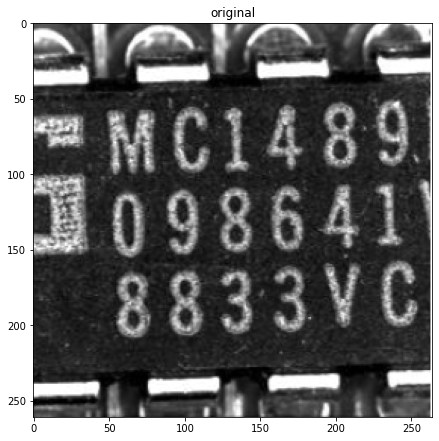

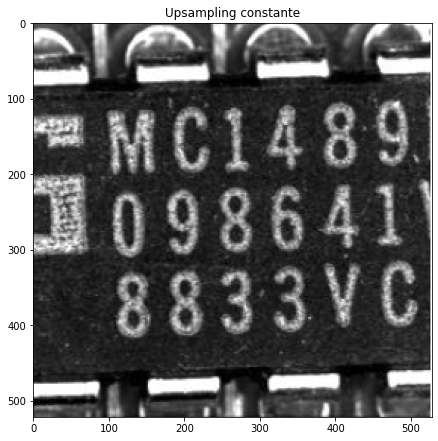

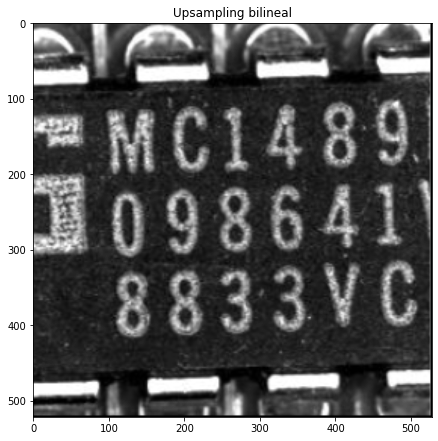

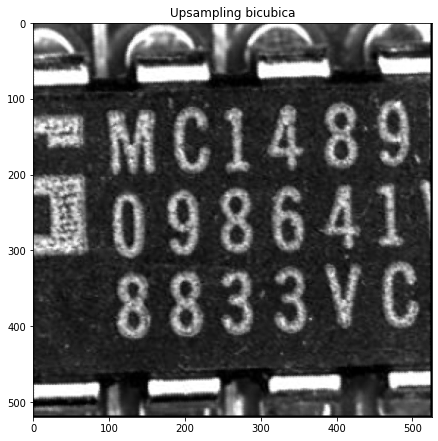

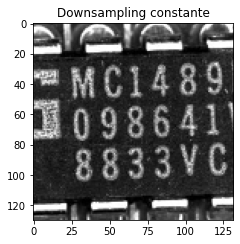

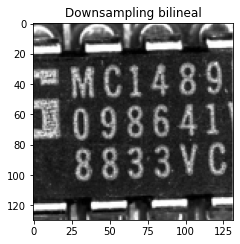

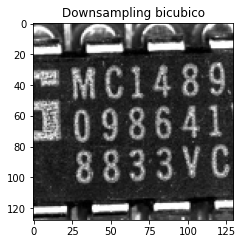

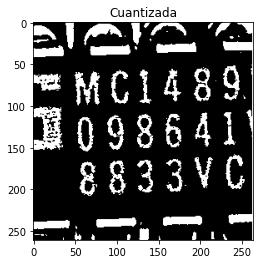

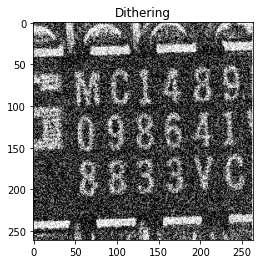

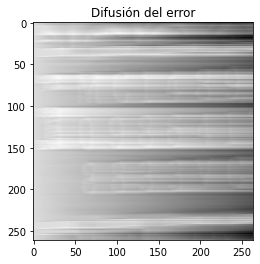

In [22]:
dpi = plt.rcParams['figure.dpi']
figsize1 = widthY / float(dpi), heightY / float(dpi)
figsize2 = 2*widthY / float(dpi), 2*heightY / float(dpi)

plt.figure(figsize = figsize2)
plt.title("original")
plt.imshow(Y,'gray')

plt.figure(figsize = figsize2)
plt.title("Upsampling constante")
plt.imshow(Yupcte,'gray')
plt.figure(figsize = figsize2)
plt.title("Upsampling bilineal")
plt.imshow(Yupbili,'gray')
plt.figure(figsize = figsize2)
plt.title("Upsampling bicubica")
plt.imshow(Yupbicu,'gray')


plt.figure(figsize = figsize1)
plt.title("Downsampling constante")
plt.imshow(Ydowncte,'gray')
plt.figure(figsize = figsize1)
plt.title("Downsampling bilineal")
plt.imshow(Ydownbili,'gray')
plt.figure(figsize = figsize1)
plt.title("Downsampling bicubico")
plt.imshow(Ydownbicu,'gray')


plt.figure()
plt.title("Cuantizada")
plt.imshow(Ycuant,'gray')
plt.figure()
plt.title("Dithering")
plt.imshow(Ydit,'gray')
plt.figure()
plt.title("Difusión del error")
plt.imshow(Ydif,'gray')

# Análisis de resultados
